<a href="https://colab.research.google.com/github/NLinh-Tran/Lending-Club-Analysis/blob/main/Lending_Club_Logistic_Regression_dti%2C_loan_amnt_distribution_(may_21).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
wordsforthewise_lending_club_path = kagglehub.dataset_download('wordsforthewise/lending-club')

print('Data source import complete.')


Data source import complete.


In [ ]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/lending-club/rejected_2007_to_2018Q4.csv.gz
/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz
/kaggle/input/lending-club/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv
/kaggle/input/lending-club/rejected_2007_to_2018q4.csv/rejected_2007_to_2018Q4.csv


# Install PySpark

In [ ]:
!pip install PySpark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import logging
import sys
import os

print('Import Libraries')

Import Libraries


In [ ]:
spark = SparkSession.builder                                        \
                    .appName("LendingClubAnalysis")                 \
                    .config("spark.ui.showConsoleProgress","false") \
                    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

In [ ]:
accepted_df = spark.read.option("header", True)                                             \
                        .option("inferSchema", True)                                        \
                        .option("multiLine", True)                                          \
                        .option("escape", '"')                                              \
                        .csv("/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz")

rejected_df = spark.read.option("header", True)                                            \
                        .option("inferSchema", True)                                        \
                        .option("multiLine", True)                                          \
                        .option("escape", '"')                                              \
                        .csv("/kaggle/input/lending-club/rejected_2007_to_2018Q4.csv.gz")

# Combined Dataset
* loan_amnt
* emp_length
* accepted_flag

#### Updates:
* dti - **0<= dti <= 100**
* addr_state - **REMOVED**
* policy_code - **REMOVED**

In [ ]:
# Accpeted
accepted_c = accepted_df.withColumn('accepted_flag', lit(1)) \
                         .select('loan_amnt', 'emp_length', 'dti', 'accepted_flag')

# Rejected
rejected_c = rejected_df.withColumnRenamed('Amount Requested', 'loan_amnt') \
                         .withColumnRenamed('Employment Length', 'emp_length') \
                         .withColumn('dti', regexp_replace(col('Debt-To-Income Ratio'), '%', '').cast('double')) \
                         .withColumn('accepted_flag', lit(0)) \
                         .select('loan_amnt', 'emp_length', 'dti', 'accepted_flag')

In [ ]:
# Combine 2 datsets
combined_df = accepted_c.union(rejected_c)

combined_df = combined_df.withColumn('emp_length_years',
                                      when(col('emp_length') == '< 1 year', 0)
                                      .when(col('emp_length') == '1 year', 1)
                                      .when(col('emp_length') == '2 years', 2)
                                      .when(col('emp_length') == '3 years', 3)
                                      .when(col('emp_length') == '4 years', 4)
                                      .when(col('emp_length') == '5 years', 5)
                                      .when(col('emp_length') == '6 years', 6)
                                      .when(col('emp_length') == '7 years', 7)
                                      .when(col('emp_length') == '8 years', 8)
                                      .when(col('emp_length') == '9 years', 9)
                                      .when(col('emp_length') == '10+ years', 10)
                                      .when(col('emp_length').isNull(), -1)
                                      .otherwise(-1)) \
                          .filter((col('dti') >= 0) & (col('dti') <= 100))

combined_df = combined_df.drop('emp_length')

In [ ]:
from pyspark.sql.functions import col, sum as spark_sum
combined_df.select([
    spark_sum(col(c).isNull().cast("int")).alias(c)
    for c in combined_df.columns
]).toPandas()

,loan_amnt,dti,accepted_flag,emp_length_years
0,0,0,0,0


In [ ]:
combined_df.count()

27894101

# Assemble Features

* features: contains a single vector of all features per row
* label: the outcome trying to predict

In [ ]:
from pyspark.ml.feature import VectorAssembler

feature_cols = ["loan_amnt", "dti", "emp_length_years"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Split into Train and Test Sets (80:20)
with random_state(seed) = 42

In [ ]:
train_df, test_df = combined_df.randomSplit([0.8, 0.2], seed=42)

# Train the Logistic Regression Model

In [ ]:
from pyspark.ml.classification import LogisticRegression

# Transform both sets so they contain 'features'
train_assembled = assembler.transform(train_df)
test_assembled = assembler.transform(test_df)

# Train the model
lr = LogisticRegression(featuresCol="features", labelCol="accepted_flag")
model = lr.fit(train_assembled)

# Coefficients

In [ ]:
coeffs = model.coefficients.toArray()
for feature, coef in zip(feature_cols, coeffs):
    print(f"{feature}: {coef}")

loan_amnt: 1.9387059482964418e-05
dti: -0.017948761490472177
emp_length_years: 0.4164047813227267


### **NOTES**:
* **emp_length_years** - the most influential and positively associated with approval - the longer of employment, the more likely loans are to be accepted
* **dti** - minor negative influence - the higher the DTI, the lower probability of being accepted
* **loan_amnt** - almost no impact

In [ ]:
coef_df = pd.DataFrame({
    "feature": feature_cols,
    "coefficient": coeffs
})
coef_df["abs_coefficient"] = np.abs(coef_df["coefficient"])
coef_df_sorted = coef_df.sort_values("abs_coefficient", ascending=False)
coef_df_sorted

,feature,coefficient,abs_coefficient
2,emp_length_years,0.416405,0.416405
1,dti,-0.017949,0.017949
0,loan_amnt,0.000019,0.000019


### **DTI Notes**:
* the majority fall between 0-40 --> might be a signal to the model that DTI doesnt help much in separating accepted vs rejected
  * check dti range from Accepted and Rejected
* The model sees very few examples of very high DTI --> dont have enough examples to learn a strong signal from distinguish between good vs bad applications --> especially when compared to **emp_length_years**
* **Red flag**: DTI in the highest bucket is kinda spike --> **NEED TO CHECK**

### **Suggestions**:
##### ***1. Bucket DTI into categories***
* Low Risk 0-15
* Medium 15-30
* High 30-60
* Very High >60

--> Google to see normally how do lenders segment the DTI

##### ***2. Use a non-linear model (Random Forest, XGBoost)***
* just want to understand the WHAT + WHY  of non-linear and logistic regression

In [ ]:
combined_df.select("dti").summary().show()
combined_df.select("dti").rdd.flatMap(lambda x: x).histogram([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

+-------+------------------+
|summary|               dti|
+-------+------------------+
|  count|          27894101|
|   mean|25.930588497524862|
| stddev| 23.81351897625889|
|    min|               0.0|
|    25%|              9.69|
|    50%|             19.98|
|    75%|             34.19|
|    max|             100.0|
+-------+------------------+



([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
 [7167718,
  6789357,
  5350496,
  3377500,
  1968261,
  934515,
  459032,
  246577,
  144800,
  1455845])

In [ ]:
# Create DTI bucket
bucket = combined_df.withColumn(
    "dti_bucket",
    when((col("dti") >= 0) & (col("dti") < 10), "0–10")
    .when((col("dti") >= 10) & (col("dti") < 20), "10–20")
    .when((col("dti") >= 20) & (col("dti") < 30), "20–30")
    .when((col("dti") >= 30) & (col("dti") < 40), "30–40")
    .when((col("dti") >= 40) & (col("dti") < 50), "40–50")
    .when((col("dti") >= 50) & (col("dti") < 60), "50–60")
    .when((col("dti") >= 60) & (col("dti") < 70), "60–70")
    .when((col("dti") >= 70) & (col("dti") < 80), "70–80")
    .when((col("dti") >= 80) & (col("dti") < 90), "80–90")
    .when((col("dti") >= 90) & (col("dti") <= 100), "90–100")
)

# Count each bucket
bucket_counts = bucket.groupBy("dti_bucket").agg(count("*").alias("Loan Count"))

# Get total number of rows
total_count = combined_df.count()

# Convert to Pandas
bucket_df = bucket_counts.toPandas()
bucket_df["Percentage"] = (bucket_df["Loan Count"] / total_count * 100).round(2)
bucket_df = bucket_df.sort_values("dti_bucket")
bucket_df

,dti_bucket,Loan Count,Percentage
7,0–10,7167718,25.70
6,10–20,6789357,24.34
2,20–30,5350496,19.18
4,30–40,3377500,12.11
3,40–50,1968261,7.06
5,50–60,934515,3.35
0,60–70,459032,1.65
1,70–80,246577,0.88
9,80–90,144800,0.52
8,90–100,1455845,5.22


In [ ]:
from pyspark.sql.functions import round as spark_round

# Create DTI Bucket
bucket = combined_df.withColumn(
    "dti_bucket",
    when((col("dti") >= 0) & (col("dti") < 10), "0–10")
    .when((col("dti") >= 10) & (col("dti") < 20), "10–20")
    .when((col("dti") >= 20) & (col("dti") < 30), "20–30")
    .when((col("dti") >= 30) & (col("dti") < 40), "30–40")
    .when((col("dti") >= 40) & (col("dti") < 50), "40–50")
    .when((col("dti") >= 50) & (col("dti") < 60), "50–60")
    .when((col("dti") >= 60) & (col("dti") < 70), "60–70")
    .when((col("dti") >= 70) & (col("dti") < 80), "70–80")
    .when((col("dti") >= 80) & (col("dti") < 90), "80–90")
    .when((col("dti") >= 90) & (col("dti") <= 100), "90–100")
)

# Count each Bucket
bucket_counts = bucket.groupBy("dti_bucket").agg(count("*").alias("Loan Counts"))

# Count each Bucket by Accepted Flag
flag_counts = bucket.groupBy("dti_bucket", "accepted_flag").agg(count("accepted_flag").alias("Flag Counts"))

# Total
total_count = combined_df.count()

# Percentage of each Bucket
bucket_df = bucket_counts.join(flag_counts, "dti_bucket") \
                         .withColumn("Bucket/Total", spark_round(col("Loan Counts") / total_count * 100, 2)) \
                         .withColumn("Flag/Bucket", spark_round(col("Flag Counts") / col("Loan Counts") * 100, 2)) \
                         .orderBy("dti_bucket") \
                         .select("dti_bucket", "Loan Counts", "Bucket/Total", "accepted_flag", "Flag Counts", "Flag/Bucket") \
                         .toPandas()
bucket_df

,dti_bucket,Loan Counts,Bucket/Total,accepted_flag,Flag Counts,Flag/Bucket
0,0–10,7167718,25.70,1,407848,5.69
1,0–10,7167718,25.70,0,6759870,94.31
2,10–20,6789357,24.34,1,922306,13.58
3,10–20,6789357,24.34,0,5867051,86.42
4,20–30,5350496,19.18,1,682770,12.76
5,20–30,5350496,19.18,0,4667726,87.24
6,30–40,3377500,12.11,1,218834,6.48
7,30–40,3377500,12.11,0,3158666,93.52
8,40–50,1968261,7.06,1,13446,0.68
9,40–50,1968261,7.06,0,1954815,99.32


In [ ]:
import plotly.express as px

fig = px.bar(
    bucket_df,
    x='dti_bucket',
    y='Percentage',
    color='Percentage',
    color_continuous_scale='Reds',
    barmode='group',
    title='DTI Bucket'
)

fig.update_layout(
    xaxis_title='',
    yaxis_title='',
    template='simple_white'
)

fig.show()

In [ ]:
# Define custom bin ranges for DTI (0 to 100 in steps of 5)
dti_hist = combined_df.select("dti").rdd.flatMap(lambda x: x).histogram([i for i in range(0, 105, 5)])

# Unpack bins and counts
dti_bins = dti_hist[0]
dti_counts = dti_hist[1]

# Calculate midpoints for x-axis labels
dti_midpoints = [(dti_bins[i] + dti_bins[i+1]) / 2 for i in range(len(dti_bins) - 1)]

# Create DataFrame
import pandas as pd
dti_df_hist = pd.DataFrame({
    "DTI": dti_midpoints,
    "Loan Count": dti_counts
})

import plotly.express as px

fig = px.bar(
    dti_df_hist,
    x="DTI",
    y="Loan Count",
    title="DTI Distribution (Spark Histogram)",
    labels={"Loan Count": "Number of Loans"},
    height=400
)

fig.update_layout(
    xaxis_title='',
    yaxis_title='',
    template='simple_white'
)

fig.show()

In [ ]:
dti_pd = combined_df.select("dti") \
    .sample(False, 0.001, seed=42) \
    .toPandas()

import plotly.express as px
fig = px.strip(dti_pd, x="dti", title="Sampled Dot Plot of DTI", height=400)
fig.update_traces(jitter=0.3, marker=dict(size=5, opacity=0.5))
fig.update_layout(xaxis_title="DTI", yaxis_visible=False)
fig.show()

## **loan_amnt**

In [ ]:
combined_df.select("loan_amnt").summary().show()

+-------+------------------+
|summary|         loan_amnt|
+-------+------------------+
|  count|          27894101|
|   mean|12640.876970841971|
| stddev|10569.365857912691|
|    min|               0.0|
|    25%|            5000.0|
|    50%|           10000.0|
|    75%|           20000.0|
|    max|         1400000.0|
+-------+------------------+



In [ ]:
loan_pd = combined_df.select("loan_amnt") \
    .sample(False, 0.01, seed=42) \
    .toPandas()

import plotly.express as px
fig = px.strip(loan_pd, x="loan_amnt", title="Sampled Dot Plot of Loan Amounts", height=400)
fig.update_traces(jitter=0.3, marker=dict(size=5, opacity=0.5))
fig.update_layout(xaxis_title="Loan Amount", yaxis_visible=False)
fig.show()

In [ ]:
# histogram
hist = combined_df.select("loan_amnt").rdd.flatMap(lambda x: x).histogram([i for i in range(0, 1500000, 5000)])

# bins and counts
bins = hist[0]
counts = hist[1]

# Create mid-points for bar chart x-axis
mid_points = [(bins[i] + bins[i+1]) // 2 for i in range(len(bins)-1)]

import pandas as pd
df_hist = pd.DataFrame({
    "Loan Amount": mid_points,
    "Loan Count": counts
})

# bins and counts
bins = hist[0]
counts = hist[1]

# Create mid-points for bar chart x-axis
mid_points = [(bins[i] + bins[i+1]) // 2 for i in range(len(bins)-1)]

import pandas as pd
df_hist = pd.DataFrame({
    "Loan Amount": mid_points,
    "Loan Count": counts
})

import plotly.express as px

fig = px.bar(df_hist, x="Loan Amount", y="Loan Count",
             title="Loan Amount Distribution",
             height=400)

fig.update_layout(
    xaxis_title='',
    yaxis_title='',
    template='simple_white',
    yaxis_type='log'
)

fig.show()

#### **Notes for 'loan_amnt'**

You said loan_amnt has a coefficient of +0.000019 — thats tiny.

If you didnt scale loan_amnt, and the values are in the thousands, then the model says:

"To balance out this large input, Ill give it a tiny weight."

Which makes it look like loan amount has no effect, when in reality, it might.

## Evaluations

### 1. Classification Report & Confusion Matrix

              precision    recall  f1-score   support

    Rejected       0.95      0.98      0.96   5127930
    Accepted       0.65      0.38      0.48    451441

    accuracy                           0.93   5579371
   macro avg       0.80      0.68      0.72   5579371
weighted avg       0.92      0.93      0.93   5579371



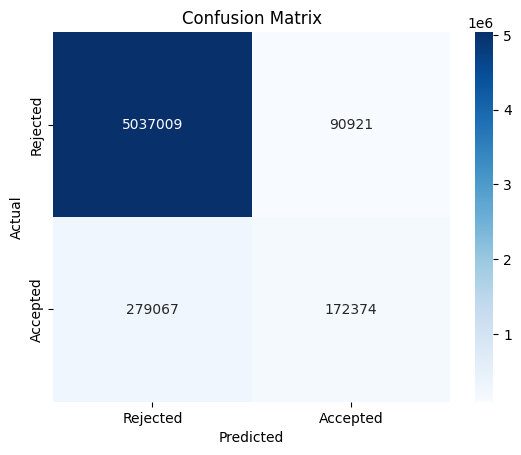

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Convert prediction results
predictions = model.transform(test_assembled)
preds_pd = predictions.select("accepted_flag", "prediction").toPandas()
print(classification_report(preds_pd["accepted_flag"], preds_pd["prediction"], target_names=["Rejected", "Accepted"]))

# Visualize Confusion Matrix
cm = confusion_matrix(preds_pd["accepted_flag"], preds_pd["prediction"])
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Rejected", "Accepted"], yticklabels=["Rejected", "Accepted"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## 2. AUC

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol="accepted_flag")
print("AUC:", evaluator.evaluate(predictions))

AUC: 0.8644822196857993
